### Step 1: Data Preprocessing

#### Load Metadata and Annotations


In [109]:
import pandas as pd

# Define file paths
metadata_file = '../dataset//development_scenes.csv'
annotations_file = '../dataset/development_scene_annotations.csv'

# Load the CSV files
metadata = pd.read_csv(metadata_file)
annotations = pd.read_csv(annotations_file)

print("Metadata:")
print(metadata.head())
print("\nAnnotations:")
print(annotations.head())


Metadata:
                        filename  speaker_id
0         2_speech_true_Ofen_aus         132
1         3_speech_true_Radio_an         132
2         4_speech_true_Alarm_an         132
3        9_speech_true_Radio_aus         132
4  11_speech_false_Fernseher_aus         132

Annotations:
                        filename       command     start       end
0    1003_speech_false_Licht_aus     Licht aus  12.20090  13.57599
1       1008_speech_true_Ofen_an       Ofen an   6.90112   8.52638
2      1010_speech_true_Radio_an      Radio an  13.03100  14.03146
3  1011_speech_true_Fernseher_an  Fernseher an  14.11030  15.36121
4   1012_speech_true_Heizung_aus   Heizung aus  11.20520  12.70590


#### Preprocess Audio Files (WAV) and Perform ICA


In [139]:
import os
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA
import numpy as np
from IPython.display import Audio

# Define directories
scenes_dir = '../dataset/scenes/wav'  # Update this path

# Function to load and preprocess audio
def load_and_preprocess_audio(file_path):
    audio, sr = librosa.load(file_path, sr=None)
    scaler = StandardScaler()
    audio = scaler.fit_transform(audio.reshape(-1, 1)).flatten()
    
    ica = FastICA(n_components=1, whiten='unit-variance')
    audio = ica.fit_transform(audio.reshape(-1, 1)).flatten()
    
    return audio, sr

# Function to segment audio based on annotations
def segment_audio(audio, sr, start, end):
    start_sample = int(start * sr)
    end_sample = int(end * sr)
    return audio[start_sample:end_sample]

# Preprocess and segment all audio files
preprocessed_segments = []

for idx, row in annotations.iterrows():
    file_name = row['filename']
    command = row['command']
    start = row['start']
    end = row['end']
    
    file_path = os.path.join(scenes_dir, file_name + '.wav')
    
    try:
        audio, sr = load_and_preprocess_audio(file_path)
        segment = segment_audio(audio, sr, start, end)
        preprocessed_segments.append((file_name, command, segment, sr))
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

# Example: display the first segment
print(f"First segment: {preprocessed_segments[0]}")


First segment: ('1003_speech_false_Licht_aus', 'Licht aus', array([ 0.08784055,  0.03521105,  0.16523688, ..., -0.15054016,
       -0.34248304, -0.2650867 ], dtype=float32), 16000)


In [143]:
import os
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import random
from IPython.display import Audio
from sklearn.decomposition import FastICA

# Function to apply ICA on audio segments
def apply_ica(segment, sr):
    ica = FastICA(n_components=1, whiten='arbitrary-variance')  # Explicitly set whiten parameter
    segment_reshaped = segment.reshape(-1, 1)
    segment_ica = ica.fit_transform(segment_reshaped).flatten()
    return segment_ica

# Function to preprocess segments and optionally save to the filesystem
def preprocess_and_save_segments(scenes_dir, annotations_path, save_dir=None, save_to_filesystem=False, apply_ica_flag=False):
    # Load the annotations
    annotations_df = pd.read_csv(annotations_path)
    
    # Ensure the save directory exists if saving to filesystem
    if save_to_filesystem and save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
    
    preprocessed_segments = []

    for index, row in annotations_df.iterrows():
        filename = row['filename']
        command = row['command']
        start = row['start']
        end = row['end']
        
        # Load the audio file
        file_path = os.path.join(scenes_dir, f"{filename}.wav")
        y, sr = librosa.load(file_path, sr=None)
        
        # Extract the segment
        start_sample = int(start * sr)
        end_sample = int(end * sr)
        segment = y[start_sample:end_sample]
        
        # Normalize the segment
        segment = librosa.util.normalize(segment)
        
        # Apply ICA if the flag is set
        if apply_ica_flag:
            segment = apply_ica(segment, sr)
        
        # Add the segment to the list
        preprocessed_segments.append((filename, command, segment, sr))
        
        # Save the segment to the filesystem if required
        if save_to_filesystem and save_dir is not None:
            save_path = os.path.join(save_dir, f"{filename}_{start}_{end}.wav")
            sf.write(save_path, segment, sr)
    
    return preprocessed_segments

# Function to play a random segment from preprocessed segments
def play_random_segment(preprocessed_segments):
    # Select a random segment
    random_segment = random.choice(preprocessed_segments)
    
    filename, command, audio_data, sample_rate = random_segment
    
    # Print the command and play the audio segment
    print(f"Filename: {filename}")
    print(f"Command: {command}")
    
    return Audio(audio_data, rate=sample_rate)

# Function to play a random segment from the filesystem
def play_random_segment_from_filesystem(save_dir, annotations_path):
    # List all the preprocessed segment files
    segment_files = [f for f in os.listdir(save_dir) if f.endswith('.wav')]
    
    # Select a random segment file
    random_segment_file = random.choice(segment_files)
    random_segment_path = os.path.join(save_dir, random_segment_file)
    
    # Extract start and end times from the file name
    filename_parts = random_segment_file.split('_')
    filename = '_'.join(filename_parts[:-2])
    start_time = float(filename_parts[-2])
    end_time = float(filename_parts[-1].replace('.wav', ''))
    
    # Find the command in the annotations
    annotations_df = pd.read_csv(annotations_path)
    command_row = annotations_df[
        (annotations_df['filename'] == filename) &
        (annotations_df['start'] == start_time) &
        (annotations_df['end'] == end_time)
    ]
    
    if command_row.empty:
        print(f"No matching annotation found for {random_segment_file}")
        return
    
    command = command_row.iloc[0]['command']
    
    # Load the audio segment
    y, sr = librosa.load(random_segment_path, sr=None)
    
    # Print the command and play the audio segment
    print(f"Filename: {filename}")
    print(f"Command: {command}")
    
    return Audio(y, rate=sr)

# Example usage
scenes_dir = '../dataset/scenes/wav'
annotations_path = '../dataset/development_scene_annotations.csv'
save_dir = '../dataset/scenes/preprocessed_segments'

# Preprocess segments and save to filesystem with optional ICA
preprocessed_segments = preprocess_and_save_segments(scenes_dir, annotations_path, save_dir, save_to_filesystem=True, apply_ica_flag=True)

# Play a random segment from memory
audio_memory = play_random_segment(preprocessed_segments)
display(audio_memory)

# Play a random segment from filesystem
audio_filesystem = play_random_segment_from_filesystem(save_dir, annotations_path)
display(audio_filesystem)


Filename: 675_speech_false_Alarm_an_Lüftung_aus
Command: Alarm an


Filename: 1721_speech_true_Staubsauger_an
Command: Staubsauger an


### Step 2: Data Augmentation

#### Apply Data Augmentation


In [144]:
import librosa
import numpy as np

# Function to augment audio
def augment_audio(audio, sr):
    augmented = []
    # Original length
    original_length = len(audio)
    
    # Shift
    shift = int(sr * 0.5)  # shift by 0.5 seconds
    shifted_audio = np.roll(audio, shift)
    augmented.append(shifted_audio)
    
    # Stretch
    stretch = librosa.effects.time_stretch(audio, rate=0.8)
    if len(stretch) < original_length:
        # Pad with zeros if stretched audio is shorter
        stretch = np.pad(stretch, (0, original_length - len(stretch)), mode='constant')
    else:
        stretch = stretch[:original_length]  # ensure same length
    augmented.append(stretch)
    
    # Debug information
    for aug_audio in augmented:
        #print(f"Original length: {original_length}, Augmented length: {len(aug_audio)}")
        if len(aug_audio) < 2048:
            print(f"Warning: Augmented segment length {len(aug_audio)} is shorter than n_fft=2048")
    
    return augmented

# Apply augmentation to all segments
augmented_segments = []
for file_name, command, segment, sr in preprocessed_segments:
    augmented = augment_audio(segment, sr)
    for aug in augmented:
        augmented_segments.append((file_name, command, aug, sr))

# Combine original and augmented data
all_segments = preprocessed_segments + augmented_segments


/usr/local/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=800
  warnings.warn(


### Step 3: Feature Extraction

#### Extract Features with Padding/Truncation and Dynamic `n_fft`


In [146]:
# Function to extract features with dynamic n_fft
def extract_features(segment, sr, max_length):
    n_fft = min(2048, max(256, len(segment) // 2))  # Ensure n_fft is not larger than half the segment length and at least 256
    if len(segment) < n_fft:
        n_fft = len(segment) // 2
    #print(f"Extracting features with n_fft={n_fft} for segment length={len(segment)}")
    hop_length = n_fft // 4  # Typical value for hop_length
    mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length)
    mfccs_flat = mfccs.flatten()
    if len(mfccs_flat) < max_length:
        # Pad with zeros
        padded_mfccs = np.pad(mfccs_flat, (0, max_length - len(mfccs_flat)), mode='constant')
        return padded_mfccs
    else:
        # Truncate to max_length
        return mfccs_flat[:max_length]

# Determine the maximum length for padding/truncation
max_length = 0
for _, _, segment, sr in all_segments:
    n_fft = min(2048, max(256, len(segment) // 2))
    if len(segment) < n_fft:
        n_fft = len(segment) // 2
    hop_length = n_fft // 4
    features = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13, n_fft=n_fft, hop_length=hop_length).flatten()
    if len(features) > max_length:
        max_length = len(features)

# Extract features for all segments with padding/truncation
feature_data = []
for file_name, command, segment, sr in all_segments:
    features = extract_features(segment, sr, max_length)
    feature_data.append((file_name, command, features))

print(f"Feature extraction completed with max length: {max_length}")


Feature extraction completed with max length: 1170


### Step 4: Model Training and Evaluation

#### Train `GradientBoostingClassifier` with Class Weights and Progress Bar


In [147]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Prepare data for training
X = np.array([features for _, _, features in feature_data])
y = np.array([command for _, command, _ in feature_data])

# Encode string labels to numeric labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

# Print class weights for debugging
print("Class Weights: ", class_weight_dict)

# Create sample weights
sample_weights = np.array([class_weight_dict[cls] for cls in y_train])

# Print sample weights for debugging
print("Sample Weights: ", sample_weights)


Class Weights:  {0: 0.9740853658536586, 1: 1.065, 2: 0.8729508196721312, 3: 1.298780487804878, 4: 0.9128571428571428, 5: 1.0240384615384615, 6: 0.8192307692307692, 7: 0.7717391304347826, 8: 1.0047169811320755, 9: 1.0579470198675496, 10: 1.0240384615384615, 11: 1.117132867132867, 12: 1.109375, 13: 0.9508928571428571, 14: 1.0721476510067114, 15: 1.2011278195488722}
Sample Weights:  [1.00471698 0.77173913 1.065      ... 1.109375   1.05794702 0.97408537]


In [148]:
# Print class distribution
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution: ", class_distribution)


Class Distribution:  {0: 164, 1: 150, 2: 183, 3: 123, 4: 175, 5: 156, 6: 195, 7: 207, 8: 159, 9: 151, 10: 156, 11: 143, 12: 144, 13: 168, 14: 149, 15: 133}


In [115]:
# Train a Gradient Boosting classifier with a progress bar and sample weights
n_estimators = 100
gb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42, warm_start=True)

# Wrap the training loop with tqdm for the progress bar
for i in tqdm(range(1, n_estimators + 1), desc="Training Gradient Boosting Classifier"):
    gb.n_estimators = i
    gb.fit(X_train, y_train, sample_weight=sample_weights)

# Evaluate the classifier
y_pred_gb = gb.predict(X_val)
print("Gradient Boosting Classifier Report")
print(classification_report(y_val, y_pred_gb, zero_division=0))


Training Gradient Boosting Classifier: 100%|██████████| 100/100 [10:51<00:00,  6.51s/it]

Gradient Boosting Classifier Report
              precision    recall  f1-score   support

           0       0.30      0.41      0.35        34
           1       0.20      0.14      0.16        36
           2       0.13      0.18      0.15        39
           3       0.20      0.21      0.20        24
           4       0.20      0.19      0.19        53
           5       0.09      0.07      0.08        45
           6       0.27      0.41      0.32        39
           7       0.42      0.55      0.48        51
           8       0.09      0.10      0.09        30
           9       0.09      0.07      0.08        41
          10       0.16      0.24      0.19        33
          11       0.25      0.22      0.24        49
          12       0.13      0.10      0.11        51
          13       0.23      0.18      0.20        39
          14       0.19      0.12      0.15        40
          15       0.40      0.23      0.29        35

    accuracy                           0.22 

#### Train `RandomForestClassifier` with Class Weights


In [149]:
# Train a Random Forest classifier with class weights
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)
rf.fit(X_train, y_train)

# Evaluate the classifier
y_pred_rf = rf.predict(X_val)
print("Random Forest Classifier Report")
print(classification_report(y_val, y_pred_rf, zero_division=0))


Random Forest Classifier Report
              precision    recall  f1-score   support

           0       0.29      0.59      0.39        34
           1       0.27      0.22      0.24        36
           2       0.25      0.36      0.29        39
           3       0.22      0.17      0.19        24
           4       0.26      0.23      0.24        53
           5       0.27      0.09      0.13        45
           6       0.18      0.36      0.24        39
           7       0.41      0.53      0.46        51
           8       0.33      0.43      0.37        30
           9       0.41      0.34      0.37        41
          10       0.22      0.18      0.20        33
          11       0.37      0.20      0.26        49
          12       0.54      0.25      0.35        51
          13       0.38      0.31      0.34        39
          14       0.29      0.25      0.27        40
          15       0.34      0.40      0.37        35

    accuracy                           0.31     

### Step 5: Ensemble Classifiers


In [117]:
from sklearn.ensemble import VotingClassifier

# Combine Random Forest and Gradient Boosting
ensemble = VotingClassifier(estimators=[('rf', rf), ('gb', gb)], voting='soft')
ensemble.fit(X_train, y_train)

# Evaluate the ensemble classifier
y_pred_ensemble = ensemble.predict(X_val)
print("Ensemble Classifier Report")
print(classification_report(y_val, y_pred_ensemble, zero_division=0))

# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

labels = np.unique(y_val)
plot_confusion_matrix(y_val, y_pred_ensemble, labels, title='Confusion Matrix - Ensemble')


KeyboardInterrupt: 

### Summary

We've consolidated the process into five clear steps:

1. **Data Preprocessing**: Load metadata and preprocess audio files with ICA.
2. **Data Augmentation**: Apply time-shifting and time-stretching to augment the audio data.
3. **Feature Extraction**: Extract MFCC features with appropriate padding/truncation and dynamic `n_fft`.
4. **Model Training and Evaluation**: Train `GradientBoostingClassifier` and `RandomForestClassifier`, handle class weights, and evaluate their performance.
5. **Ensemble Classifiers**: Combine predictions from multiple models to improve robustness.

Let's proceed with running these steps sequentially to ensure there are no errors, warnings, or obstacles. If you encounter any issues or need further adjustments, please let me know!

### Alternative ensembling method: Stacking

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Define base classifiers
estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weight_dict)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]

# Define stacking classifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred_stacking = stacking_clf.predict(X_val)

# Evaluate the stacking classifier
print("Stacking Classifier Report")
print(classification_report(y_val, y_pred_stacking, zero_division=0))


In [ ]:
class_weight_dict

### Step-by-Step Guide to Adding a CNN Classifier

1. **Define the CNN Architecture**: We'll use Keras with TensorFlow backend to define the CNN.
2. **Prepare Data for CNN**: Ensure the data is in the right shape and format for the CNN.
3. **Train the CNN**: Train the CNN on the training data.
4. **Evaluate the CNN**: Evaluate its performance on the validation data.
5. **Compare with Other Classifiers**: Compare the CNN's performance with the Gradient Boosting and Random Forest classifiers.

### Step 1: Define the CNN Architecture

We'll use a simple CNN architecture for this example.


In [150]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

# Define the CNN model
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


### Step 2: Prepare Data for CNN

Ensure the data is reshaped and formatted correctly for the CNN.


In [151]:
import math

# Convert the feature data to a numpy array
X_cnn = np.array([features for _, _, features in feature_data])
y_cnn = np.array([command for _, command, _ in feature_data])

# Encode string labels to numeric labels
y_cnn_encoded = label_encoder.transform(y_cnn)

# Convert labels to categorical
y_cnn_categorical = to_categorical(y_cnn_encoded)

# Determine input shape for CNN
num_features = X_cnn.shape[1]
# Calculate the dimensions (height and width) such that height * width = num_features
# Here, we aim for the closest possible square dimensions
height = int(math.sqrt(num_features))
width = height
if height * width < num_features:
    width += 1

# Adjust the number of features to match the closest square dimensions
num_adjusted_features = height * width
X_cnn_adjusted = np.zeros((X_cnn.shape[0], num_adjusted_features))
X_cnn_adjusted[:, :num_features] = X_cnn

# Reshape to (num_samples, height, width, 1)
X_cnn_reshaped = X_cnn_adjusted.reshape(-1, height, width, 1)

# Split data into training and validation sets
X_train_cnn, X_val_cnn, y_train_cnn, y_val_cnn = train_test_split(X_cnn_reshaped, y_cnn_categorical, test_size=0.2, random_state=42)

# Print shapes for debugging
print(f"X_cnn shape: {X_cnn.shape}")
print(f"X_cnn_adjusted shape: {X_cnn_adjusted.shape}")
print(f"X_cnn_reshaped shape: {X_cnn_reshaped.shape}")
print(f"X_train_cnn shape: {X_train_cnn.shape}")
print(f"X_val_cnn shape: {X_val_cnn.shape}")


X_cnn shape: (3195, 1170)
X_cnn_adjusted shape: (3195, 1190)
X_cnn_reshaped shape: (3195, 34, 35, 1)
X_train_cnn shape: (2556, 34, 35, 1)
X_val_cnn shape: (639, 34, 35, 1)


### Step 3: Train the CNN


In [152]:
# Create the CNN model
input_shape = (height, width, 1)
num_classes = len(np.unique(y_train_cnn.argmax(axis=1)))
cnn_model = create_cnn_model(input_shape, num_classes)

# Train the CNN model
cnn_model.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=32, validation_data=(X_val_cnn, y_val_cnn))


Epoch 1/10


/usr/local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.0677 - loss: 8.4797 - val_accuracy: 0.0923 - val_loss: 2.7666
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1700 - loss: 2.6105 - val_accuracy: 0.1518 - val_loss: 2.6487
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2999 - loss: 2.2166 - val_accuracy: 0.2050 - val_loss: 2.5668
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4296 - loss: 1.8310 - val_accuracy: 0.1987 - val_loss: 2.6880
Epoch 5/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5501 - loss: 1.4300 - val_accuracy: 0.2160 - val_loss: 2.7961
Epoch 6/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7329 - loss: 0.9272 - val_accuracy: 0.2113 - val_loss: 2.8743
Epoch 7/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8365 - loss: 0.6035 - val_accuracy: 0.2676 - val_loss: 3.2219
Epoch 8/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9282 - loss: 0.3136 - val_accuracy: 0.2567 - val_loss: 3.

### Step 4: Evaluate the CNN


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2757 - loss: 4.0872
CNN Model Accuracy: 0.2644757330417633
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Classifier Report
              precision    recall  f1-score   support

           0       0.29      0.29      0.29        34
           1       0.30      0.28      0.29        36
           2       0.16      0.13      0.14        39
           3       0.15      0.08      0.11        24
           4       0.17      0.26      0.21        53
           5       0.19      0.16      0.17        45
           6       0.23      0.28      0.26        39
           7       0.39      0.55      0.46        51
           8       0.28      0.30      0.29        30
           9       0.33      0.27      0.30        41
          10       0.16      0.09      0.12        33
          11       0.22      0.22      0.22        49
          12       0.23      0.27      0.25        51
          13       0.32      0.28      0.30        39
          14    

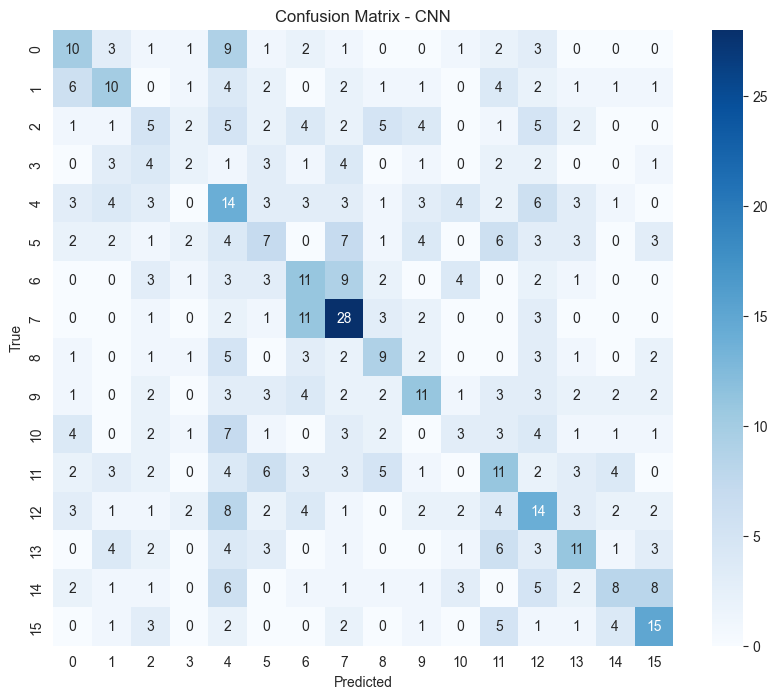

In [153]:
# Evaluate the CNN model
cnn_eval = cnn_model.evaluate(X_val_cnn, y_val_cnn)
print(f"CNN Model Accuracy: {cnn_eval[1]}")

# Make predictions
y_pred_cnn = cnn_model.predict(X_val_cnn)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_val_cnn_classes = np.argmax(y_val_cnn, axis=1)

# Print classification report
print("CNN Classifier Report")
print(classification_report(y_val_cnn_classes, y_pred_cnn_classes, zero_division=0))

# Plot confusion matrix for CNN
plot_confusion_matrix(y_val_cnn_classes, y_pred_cnn_classes, labels, title='Confusion Matrix - CNN')


### Step 5: Compare with Other Classifiers

You already have the evaluation metrics for the Gradient Boosting and Random Forest classifiers. Now you can compare the performance of the CNN with these classifiers.

### Summary

1. **Define CNN Architecture**: Use Keras to define a simple CNN.
2. **Prepare Data**: Reshape the feature data and convert labels to categorical format.
3. **Train CNN**: Train the CNN model on the training data.
4. **Evaluate CNN**: Evaluate the CNN's performance and compare it with other classifiers.

Run the above code step-by-step and compare the results. Let me know if you encounter any issues or need further adjustments!

Class Distribution in Training Set: Counter({'Licht aus': 207, 'Licht an': 195, 'Fernseher an': 183, 'Heizung an': 175, 'Radio aus': 168, 'Alarm an': 164, 'Lüftung an': 159, 'Ofen an': 156, 'Heizung aus': 156, 'Lüftung aus': 151, 'Alarm aus': 150, 'Staubsauger an': 149, 'Radio an': 144, 'Ofen aus': 143, 'Staubsauger aus': 133, 'Fernseher aus': 123})


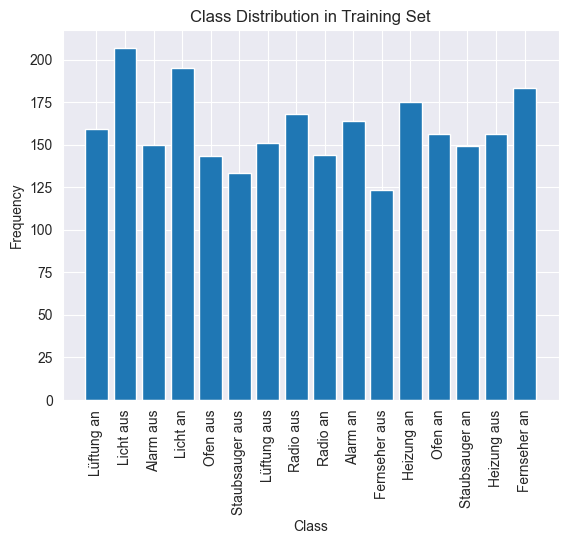

In [154]:
from collections import Counter

# Check class distribution in the training set
y_train_labels = label_encoder.inverse_transform(y_train)
class_distribution = Counter(y_train_labels)
print("Class Distribution in Training Set:", class_distribution)

# Visualize class distribution
import matplotlib.pyplot as plt

plt.bar(class_distribution.keys(), class_distribution.values())
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=90)
plt.show()


## Using Spectrograms and CNN

1. **Preprocess Audio Data into Spectrograms**: Convert each audio segment into a Mel spectrogram.
2. **Prepare Data for CNN**: Ensure the spectrograms are reshaped and formatted correctly for the CNN.
3. **Define a More Complex CNN**: Use a more complex CNN architecture to handle the spectrogram data.
4. **Train and Evaluate the CNN**: Train the CNN on the training data and evaluate its performance.

### Step 1: Preprocess Audio Data into Spectrograms


In [155]:
import librosa
import numpy as np

# Function to extract spectrogram features
def extract_spectrogram(segment, sr, n_mels=128, fmax=8000):
    spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, fmax=fmax)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram_db

# Apply the spectrogram extraction to all segments
spectrogram_data = []
for file_name, command, segment, sr in all_segments:
    spectrogram = extract_spectrogram(segment, sr)
    spectrogram_data.append((file_name, command, spectrogram))

# Determine the maximum shape for padding
max_shape = max([s.shape for _, _, s in spectrogram_data], key=lambda x: x[1])
print(f"Maximum spectrogram shape: {max_shape}")


/usr/local/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=800
  warnings.warn(


Maximum spectrogram shape: (128, 90)


### Step 2: Prepare Data for CNN


In [156]:
# Pad spectrograms to have the same shape
padded_spectrograms = []
for file_name, command, spectrogram in spectrogram_data:
    pad_width = max_shape[1] - spectrogram.shape[1]
    padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    padded_spectrograms.append((file_name, command, padded_spectrogram))

# Convert to numpy arrays and reshape
X_spectrogram = np.array([s for _, _, s in padded_spectrograms])
X_spectrogram = X_spectrogram[..., np.newaxis]  # Add channel dimension
y_spectrogram = np.array([command for _, command, _ in padded_spectrograms])

# Encode string labels to numeric labels
y_encoded = label_encoder.transform(y_spectrogram)
y_categorical = to_categorical(y_encoded)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_spectrogram, y_categorical, test_size=0.2, random_state=42)

# Print shapes for debugging
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")


X_train shape: (2556, 128, 90, 1)
X_val shape: (639, 128, 90, 1)
y_train shape: (2556, 16)
y_val shape: (639, 16)


### Step 3: Define a More Complex CNN


In [157]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define a more complex CNN model
def create_complex_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the complex CNN model
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
num_classes = y_train.shape[1]
complex_cnn_model = create_complex_cnn_model(input_shape, num_classes)


/usr/local/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


### Step 4: Train and Evaluate the CNN


In [ ]:
# Train the complex CNN model
complex_cnn_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the CNN model
cnn_eval = complex_cnn_model.evaluate(X_val, y_val)
print(f"CNN Model Accuracy: {cnn_eval[1]}")

# Make predictions
y_pred_cnn = complex_cnn_model.predict(X_val)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Print classification report
print("CNN Classifier Report")
print(classification_report(y_val_classes, y_pred_cnn_classes, zero_division=0))

# Plot confusion matrix for CNN
plot_confusion_matrix(y_val_classes, y_pred_cnn_classes, labels, title='Confusion Matrix - CNN')


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.0703 - loss: 13.7394 - val_accuracy: 0.0720 - val_loss: 2.7597
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 19s 231ms/step - accuracy: 0.0905 - loss: 2.7342 - val_accuracy: 0.0939 - val_loss: 2.7500
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 221ms/step - accuracy: 0.0952 - loss: 2.7016 - val_accuracy: 0.0814 - val_loss: 2.7682
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 221ms/step - accuracy: 0.1090 - loss: 2.7215 - val_accuracy: 0.0736 - val_loss: 2.7423
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 18s 219ms/step - accuracy: 0.1010 - loss: 2.7039 - val_accuracy: 0.1064 - val_loss: 2.7379
Epoch 6/20
13/80 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.1170 - loss: 2.6645

### Summary

1. **Preprocess Audio Data**: Convert audio segments to Mel spectrograms.
2. **Prepare Data**: Pad spectrograms to the same shape and split the data into training and validation sets.
3. **Define CNN**: Use a more complex CNN architecture to handle the spectrogram data.
4. **Train and Evaluate**: Train the CNN and evaluate its performance, then compare with the other classifiers.

Run the above code step-by-step to see how the CNN performs with the spectrogram data. If you encounter any issues or need further adjustments, please let me know!

## Variant: Spectrograms and Conv1D CNN

1. **Prepare Data for Conv1D Model**: Ensure the data is in the right shape and format for the Conv1D model.
2. **Define the Conv1D Model**: Use the provided Conv1D architecture.
3. **Train and Evaluate the Conv1D Model**: Train the Conv1D model on the training data and evaluate its performance.

### Step 1: Prepare Data for Conv1D Model

The Conv1D model expects the data to have the shape `(num_samples, timesteps, features)`. Since we have spectrogram data, we can treat each column of the spectrogram as a timestep.


In [127]:
import librosa
import numpy as np
from tensorflow.keras.utils import to_categorical

# Function to extract spectrogram features
def extract_spectrogram(segment, sr, n_mels=128, fmax=8000):
    spectrogram = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels, fmax=fmax)
    spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
    return spectrogram_db

# Apply the spectrogram extraction to all segments
spectrogram_data = []
for file_name, command, segment, sr in all_segments:
    spectrogram = extract_spectrogram(segment, sr)
    spectrogram_data.append((file_name, command, spectrogram))

# Determine the maximum shape for padding
max_shape = max([s.shape for _, _, s in spectrogram_data], key=lambda x: x[1])
print(f"Maximum spectrogram shape: {max_shape}")

# Pad spectrograms to have the same shape
padded_spectrograms = []
for file_name, command, spectrogram in spectrogram_data:
    pad_width = max_shape[1] - spectrogram.shape[1]
    padded_spectrogram = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
    padded_spectrograms.append((file_name, command, padded_spectrogram))

# Convert to numpy arrays and reshape
X_spectrogram = np.array([s for _, _, s in padded_spectrograms])
X_spectrogram = X_spectrogram.transpose((0, 2, 1))  # Transpose to (num_samples, timesteps, n_mels)
X_spectrogram = X_spectrogram[..., np.newaxis]  # Add channel dimension
y_spectrogram = np.array([command for _, command, _ in padded_spectrograms])

# Encode string labels to numeric labels
y_encoded = label_encoder.transform(y_spectrogram)
y_categorical = to_categorical(y_encoded)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_spectrogram, y_categorical, test_size=0.2, random_state=42)

# Print shapes for debugging
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")


/usr/local/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=800
  warnings.warn(


Maximum spectrogram shape: (128, 90)
X_train shape: (2556, 90, 128, 1)
X_val shape: (639, 90, 128, 1)
y_train shape: (2556, 16)
y_val shape: (639, 16)


### Step 2: Define the Conv1D Model

Use the provided Conv1D architecture:


In [128]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input

# Define the Conv1D model with Input layer
input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential([
    Input(shape=input_shape),  # Use Input layer to define the input shape
    # First Conv1D layer
    Conv1D(filters=8, kernel_size=3, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Second Conv1D layer
    Conv1D(filters=16, kernel_size=3, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Third Conv1D layer
    Conv1D(filters=32, kernel_size=3, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Fourth Conv1D layer
    Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu', strides=1),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    # Flatten layer
    Flatten(),

    # Dense Layer 1
    Dense(256, activation='relu'),
    Dropout(0.3),

    # Dense Layer 2
    Dense(128, activation='relu'),
    Dropout(0.3),

    # Output layer
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary for debugging
model.summary()


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)                   │ (None, 88, 8)               │           3,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_16 (MaxPooling1D)      │ (None, 44, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 44, 8)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_17 (Conv1D)                   │ (None, 42, 16)              │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_17 (MaxPooling1D)      │ (None, 21, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 21, 16)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_18 (Conv1D)                   │ (None, 19, 32)              │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_18 (MaxPooling1D)      │ (None, 9, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 9, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_19 (Conv1D)                   │ (None, 7, 64)               │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_19 (MaxPooling1D)      │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 3, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 16)                  │           2,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,624 (373.53 KB)

 Trainable params: 95,624 (373.53 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Train and Evaluate the Conv1D Model


Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.0677 - loss: 13.3814 - val_accuracy: 0.0798 - val_loss: 2.7723
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0905 - loss: 2.7704 - val_accuracy: 0.0798 - val_loss: 2.7722
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0886 - loss: 2.7665 - val_accuracy: 0.0798 - val_loss: 2.7721
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0814 - loss: 2.7663 - val_accuracy: 0.0798 - val_loss: 2.7715
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0733 - loss: 2.7635 - val_accuracy: 0.0798 - val_loss: 2.7720
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0916 - loss: 2.7633 - val_accuracy: 0.0798 - val_loss: 2.7715
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0830 - loss: 2.7656 - val_accuracy: 0.0798 - val_loss: 2.7711
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0752 - loss: 2.7663 - val_accuracy: 0.0798 - 

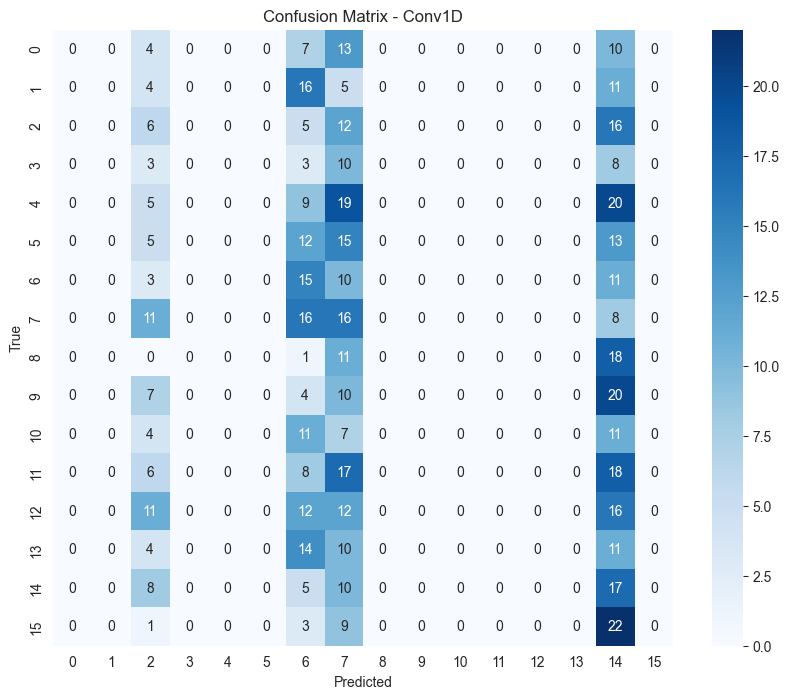

In [129]:
# Train the Conv1D model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the Conv1D model
cnn_eval = model.evaluate(X_val, y_val)
print(f"Conv1D Model Accuracy: {cnn_eval[1]}")

# Make predictions
y_pred_cnn = model.predict(X_val)
y_pred_cnn_classes = np.argmax(y_pred_cnn, axis=1)
y_val_classes = np.argmax(y_val, axis=1)

# Print classification report
print("Conv1D Classifier Report")
print(classification_report(y_val_classes, y_pred_cnn_classes, zero_division=0))

# Plot confusion matrix for Conv1D
plot_confusion_matrix(y_val_classes, y_pred_cnn_classes, labels, title='Confusion Matrix - Conv1D')


### Summary

1. **Prepare Data**: Reshape the spectrogram data for the Conv1D model.
2. **Define Conv1D Model**: Use the provided Conv1D architecture.
3. **Train and Evaluate**: Train the Conv1D model and evaluate its performance.

Run the above code step-by-step to see how the Conv1D model performs with the spectrogram data. If you encounter any issues or need further adjustments, please let me know!

In [130]:
import pandas as pd

# Load the CSV files
scene_annotations_df = pd.read_csv('../dataset/development_scene_annotations.csv')
scenes_df = pd.read_csv('../dataset/development_scenes.csv')

# Check the head of the dataframes to understand their structure
print(scene_annotations_df.head())
print(scenes_df.head())

# Check the distribution of labels in the annotations CSV
label_distribution_annotations = scene_annotations_df['command'].value_counts()
print("Label Distribution in development_scene_annotations.csv:")
print(label_distribution_annotations)

# Check the distribution of speaker IDs in the scenes CSV
label_distribution_scenes = scenes_df['speaker_id'].value_counts()
print("Label Distribution in development_scenes.csv:")
print(label_distribution_scenes)


                        filename       command     start       end
0    1003_speech_false_Licht_aus     Licht aus  12.20090  13.57599
1       1008_speech_true_Ofen_an       Ofen an   6.90112   8.52638
2      1010_speech_true_Radio_an      Radio an  13.03100  14.03146
3  1011_speech_true_Fernseher_an  Fernseher an  14.11030  15.36121
4   1012_speech_true_Heizung_aus   Heizung aus  11.20520  12.70590
                        filename  speaker_id
0         2_speech_true_Ofen_aus         132
1         3_speech_true_Radio_an         132
2         4_speech_true_Alarm_an         132
3        9_speech_true_Radio_aus         132
4  11_speech_false_Fernseher_aus         132
Label Distribution in development_scene_annotations.csv:
command
Licht aus          86
Licht an           78
Heizung an         76
Fernseher an       74
Radio aus          69
Heizung aus        67
Alarm an           66
Radio an           65
Lüftung aus        64
Ofen aus           64
Ofen an            63
Staubsauger an     63